# Travel Insurance Analysis : Predicting Claim

**Context**  
Sebuah perusahaan asuransi perjalanan mengumpulkan data histori klaim dari produk yang mereka tawarkan. Berdasarkan track record, perusahaan ingin mengetahui track record customer yang mengambil produk asuransi dan akhirnya mengajukan atau tidak mengajukan claim. Dari track record ini, di masa depan, costumer dengan spesikasi yang sama atau mirip dengan customer yang telah mengajukan claim akan dikategorikan sebagai perjalanan dengan resiko tinggi. Bergerak dari hasil analisis tersebut, perusahaan akan menentukan premi yang dibebankan kepada customer. Premi yang dibayarkan harus lebih besar daripada kemungkinan resiko tertanggung, atau minimal breakeven. Ketika terjadi sebaliknya, maka perusahaan akan mengalami kerugian karena premi tidak dapat menanggung seluruh akibat suatu resiko ketika ia benar - benar terjadi. Sedangkan, premi yang sudah disetujui tidak dapat direvisi setelah resiko terjadi, hasilnya perusahaan harus mengcover biaya tersebut dari margin keuntungan. Semakin besar kesalahan prediksi resiko, maka semakin besar keuntungan perusahaan tergerus. Dalam waktu lama, bukannya tidak mungkin finansial perusahaan akan terganggu dan akhirnya mengalami pailit. Oleh karena itu, diperlukan suatu metode untuk memprediksi kemungkinan resiko yang akan terjadi dalam suatu perjalanan secara akurat, agar seluruh biaya yang berpotensi akan timbul dapat tertanggung seluruhnya. Dalam hal ini kita akan memanfaatkan pemodelan machine learning.

**Goal**
1. Perusahaan ingin membuat proses assesment resiko menjadi lebih seamless dan akurat dengan model machine learning.
2. Menurunkan resiko kerugian karena hasil assesment yang tidak sesuai dengan resiko aktual.
3. Memberikan dasar penentuan premi berdasarkan pola stakeholder yang mengajukan claim.

**Target**  
Karena fokus perusahaan adalah stakeholder yang mengajukan claim, maka   
0 = Tidak mengajukan claim  
1 = Mengajukan claim

**Metric Evaluation**
1. Error tipe 1: False Positive.
    - Stakeholder diprediksi mengajukan claim ketika aktualnya tidak mengajukan claim.
    - Efeknya, ada kemungkinan premi ditentukan lebih mahal daripada nilai aktual resiko tercover.
    - Akan ada excess (keuntungan) bagi perusahaan dari hasil premi.
2. Error tipe 2: False Negative
    - Stakeholder diprediksi tidak mengajukan claim ketika aktualnya mengajukan claim.
    - Efeknya, ada kemungkinan premi yang ditentukan lebih murah daripada nilai aktual resiko tercover.
    - Premi yang terambil, tidak dapat mengcover aktual nilai claim sehingga menimbulkan kerugiaan bagi perusahaan. 
Berdasarkan analisis di atas, perusahaan ingin menekan kemunculan False Negative dalam permodelan machine learning. Sehingga, metric evaluation yang akan digunakan dalam model uji coba adalah Recall.


# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import category_encoders as ce

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier

warnings.filterwarnings('ignore')

# EDA

## Importing dataframe

In [2]:
# Import data
df = pd.read_csv('data_travel_insurance.csv')
df.head(n=5)

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


Dapat dilihat dari tabel diatas, bahwa :
1. Data yang akan diolah adalah kombinasi antara data kategorik dan numerik. Preprocessing akan dibutuhkan untuk mengubah data - data kategorik dan numerik menjadi data yang dapat diolah oleh machine learning.
2. Karena fokus kita terhadap pengajuan claim, maka, status asuransi dalam kolom 'Claim' akan menjadi target analisis.
3. Kolom target 'Claim' masih berupa data Object, sehingga perlu diubah secara manual (tidak dengan pipeline preprocess) menjadi nilai numerik.

In [3]:
# Mengubah value dalam kolom target agar menjadi nominal 0 dan 1
df['Claim'] = df['Claim'].replace({'No': '0', 'Yes': '1'})
df['Claim'] = df['Claim'].astype(int)

df.head(n=5)

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,0


Nilai dalam kolom 'Claim' sudah berhasil diubah menjadi 0 dan 1 sesuai penjelasan pada konteks sebelumnya.

## General information

## Cek kesesuaian tipe data, missing value, dan jumlah value unik

Untuk membuat pemodelan machine learning, data harus bersih dari missing value dan duplikasi. Untuk melakukan cleaning data kita perlu mengetahui karakteristik data yang kita kenali, sehingga pertama kali akan kita definisikan setiap fitur yang tersedia dalam dataframe.

In [4]:
# Extract General Information (Nama Kolom, Tipe Data, Missing Value, % Missing Value, Unique, Sample Unique)

list_item = []
for i in df.columns :
    list_item.append([
        i,
        df[i].dtype,
        df[i].isna().sum(),
        round(df[i].isna().sum()/len(df)*100),
        df[i].nunique(),
        df[i].unique()[:3]
    ])

info_df = pd.DataFrame(list_item,
                       columns='Nama Kolom, Tipe Data, Missing Value, % Missing Value, N Unique, Unique Sampe'.split(', '))
info_df

,Nama Kolom,Tipe Data,Missing Value,% Missing Value,N Unique,Unique Sampe
0,Agency,object,0,0,16,"[C2B, EPX, JZI]"
1,Agency Type,object,0,0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0,2,"[Online, Offline]"
3,Product Name,object,0,0,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Gender,object,31647,71,2,"[F, nan, M]"
5,Duration,int64,0,0,437,"[365, 4, 19]"
6,Destination,object,0,0,138,"[SINGAPORE, MALAYSIA, INDIA]"
7,Net Sales,float64,0,0,1006,"[216.0, 10.0, 22.0]"
8,Commision (in value),float64,0,0,915,"[54.0, 0.0, 7.7]"
9,Age,int64,0,0,89,"[57, 33, 26]"


Dari hasil check null values di atas:
1. Fitur di dalam data memiliki nilai yang mix antara angka dan string. Preprocessing harus dilakukan terhadap fitur yang nanti digunakan.
2. Data cenderung bersih dari missing values kecuali fitur 'Gender'. Terdapat null values yang sangat tinggi (71%) sehingga feature ini tidak dapat digunakan.
3. Setiap tipe data sudah sesuai dengan valuenya. Tidak diperlukan adanya konversi. Contohnya adalah nilai Age sudah dianggap sebagai nilai angkat, bukan string.

# Data Cleaning

Sesuai dengan analisis sebelumnya, maka Gender akan menjadi fitur yang pertama kali tereliminasi.

In [5]:
# Removing Gender from dataframe
df.drop(columns=['Gender'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Duration              44328 non-null  int64  
 5   Destination           44328 non-null  object 
 6   Net Sales             44328 non-null  float64
 7   Commision (in value)  44328 non-null  float64
 8   Age                   44328 non-null  int64  
 9   Claim                 44328 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 3.4+ MB


Setelah Gender dihilangkan dari dataframe, saat ini kita memiliki 8 fitur untuk nantinya akan dilanjutkan dalam seleksi fitur.

## Cek duplikasi data

Adanya data duplicate akan mengganggu hasil prediksi model machine learning. Pertama, kita aka melakukan pengecekan ada berapa banyak data duplicate yang kita miliki.

In [7]:
# Check for duplicate rows
duplicates = df.duplicated()
duplicate_rows = df[duplicates]
duplicate_count = duplicates.sum()
duplicate_percentage = duplicate_count/len(df)*100

print(f"Number of duplicate rows: {int(duplicate_count)}, equals to {round(float(duplicate_percentage), 2)}%")

Number of duplicate rows: 5004, equals to 11.29%


Hasilnya, ada 11.29% data duplicate di dalam dataframe yang harus kita remove.

In [8]:
df_cleaned = df.drop_duplicates()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39324 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                39324 non-null  object 
 1   Agency Type           39324 non-null  object 
 2   Distribution Channel  39324 non-null  object 
 3   Product Name          39324 non-null  object 
 4   Duration              39324 non-null  int64  
 5   Destination           39324 non-null  object 
 6   Net Sales             39324 non-null  float64
 7   Commision (in value)  39324 non-null  float64
 8   Age                   39324 non-null  int64  
 9   Claim                 39324 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 3.3+ MB


Berdasarkan cek duplikasi, terdapat data duplicate sebanyak 5004 rows atau setara 11.29%.  
Setelah dihilangkan, tersisa sebanyak 39324 data.

## Pemilihan fitur

Berapa banyak fitur dan fitur apa yang akan digunakan berkorelasi langsung terhadap kemungkinan overfitting dan underfitting. Sehingga, diperlukan adanya proses seleksi fitur yang digunakan dalam model machine learning. Dengan memastikan bahwa kita hanya menggunakan fitur - fitur yang berpengaruh, efisiensi sumber daya analisis akan terjaga. Karena, selain kemungkinan overfit, memproses terlalu banyak data juga membutuhkan waktu yang otomatis akan lebih lama.

### Fitur Numerik

Dari data yang ada, kita memiliki 4 data numerik yang dapat digunakan, yaitu Duration, Net Sales, Commision, dan Age. Untuk mengetahui relevansinya, kita dapat menggunakan nilai Pearson dengan plotting heatmap.

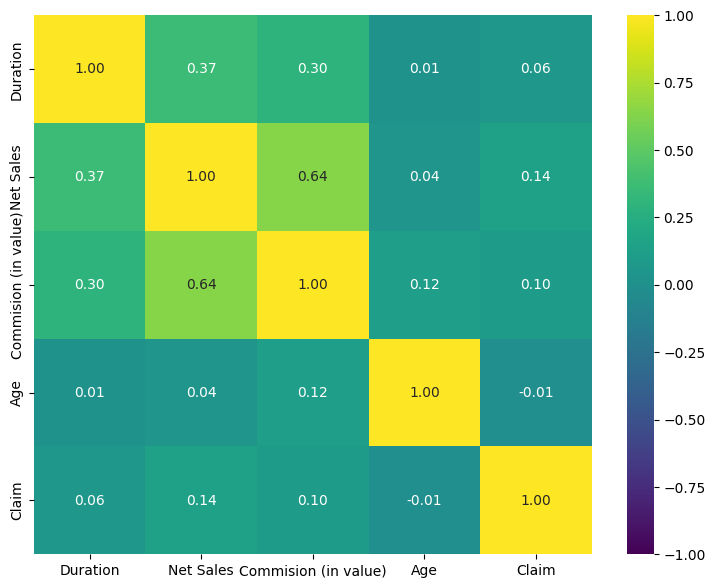

In [9]:
# Feature Selection (Numeric) dengan Pearson
num_features = df_cleaned[['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Claim']]
heatmap_num = num_features.corr()

plt.figure(figsize= (9, 7))
sns.heatmap(heatmap_num, annot=True, cmap='viridis', fmt='.2f', vmin=-1, vmax=1)
plt.show()

Berdasarkan heatmap, dengan membandingkan efek 4 fitur numerik terhadap status 'Claim':
1. Fitur Duration dan Age tidak akan digunakan karena nilai korelasi dibawah 10%
2. Fitur numerikal yang akan digunakan adalah Net Sales dan Commission (in value)
3. Namun, terdapat korelasi signifikan antara Net Sales dan Commission (in value) yaitu 0.64. Hal ini masuk akal, karena kedua fitur tersebut berkorelasi langsung dengan profit. Semakin besar Net Sales yang didapatkan suatu produk, hampir dapat dipastikan bahwa Komisi yang didapatkan oleh agen akan lebih tinggi.
4. Oleh karenanya, untuk menghindari adanya multicollinearity antara Net Sales dan Commision maka dilakukan analisa VIF lebih lanjut terhadap kedua fitur ini juga fitur numerik lainnya.

#### Cek multikolineariti di fitur numerik

Multikolinearitas akan mempengaruhi proses pemodelan machine learning. Kedua fitur yang berkorelasi sangat erat akan berperilaku sebagai hint untuk proses prediksi yan dilakukan dengan data train. Sehingga, kemungkinan akurasinya terhadap data train dan test akan tinggi, tetapi ketika dilakukan uji coba terhadap data yang benar - benar baru, performanya akan menurun. 

In [10]:
# Compute VIF for checking multicollinearity
vif_num_features = pd.DataFrame()
vif_num_features['Feature'] = num_features.columns
vif_num_features['VIF'] = [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]

print(vif_num_features)

                Feature       VIF
0              Duration  1.406308
1             Net Sales  2.948287
2  Commision (in value)  2.131918
3                   Age  1.658118
4                 Claim  1.036918


Berdasarkan hasil cek, fitur Net Sales dan Commision (in value) memiliki nilai VIF < 10 sehingga dapat dianggap memiliki tingkat kolinearitas yang rendah dan aman untuk digunakan dalam analisis.

### Fitur kategorikal

Dataframe ini memiliki cukup banyak data kategorik dengan jumlah data unik yang berbeda - beda pada setiap fiturnya.

#### Cek distribusi pada data kategorik

Untuk memahami bagaiman efek setiap fiturnya pada data, secara sederhana dapat dilihat dari distribusi pengajuan Claim pada setiap fiturnya. Asumsinya adalah, jika distribusi pengajuan claim pada setiap nilai di dalam fitur adalah berbeda, maka dapat disimpulkan fitur tersebut memiliki pengaruh terhadap munculnya Claim.

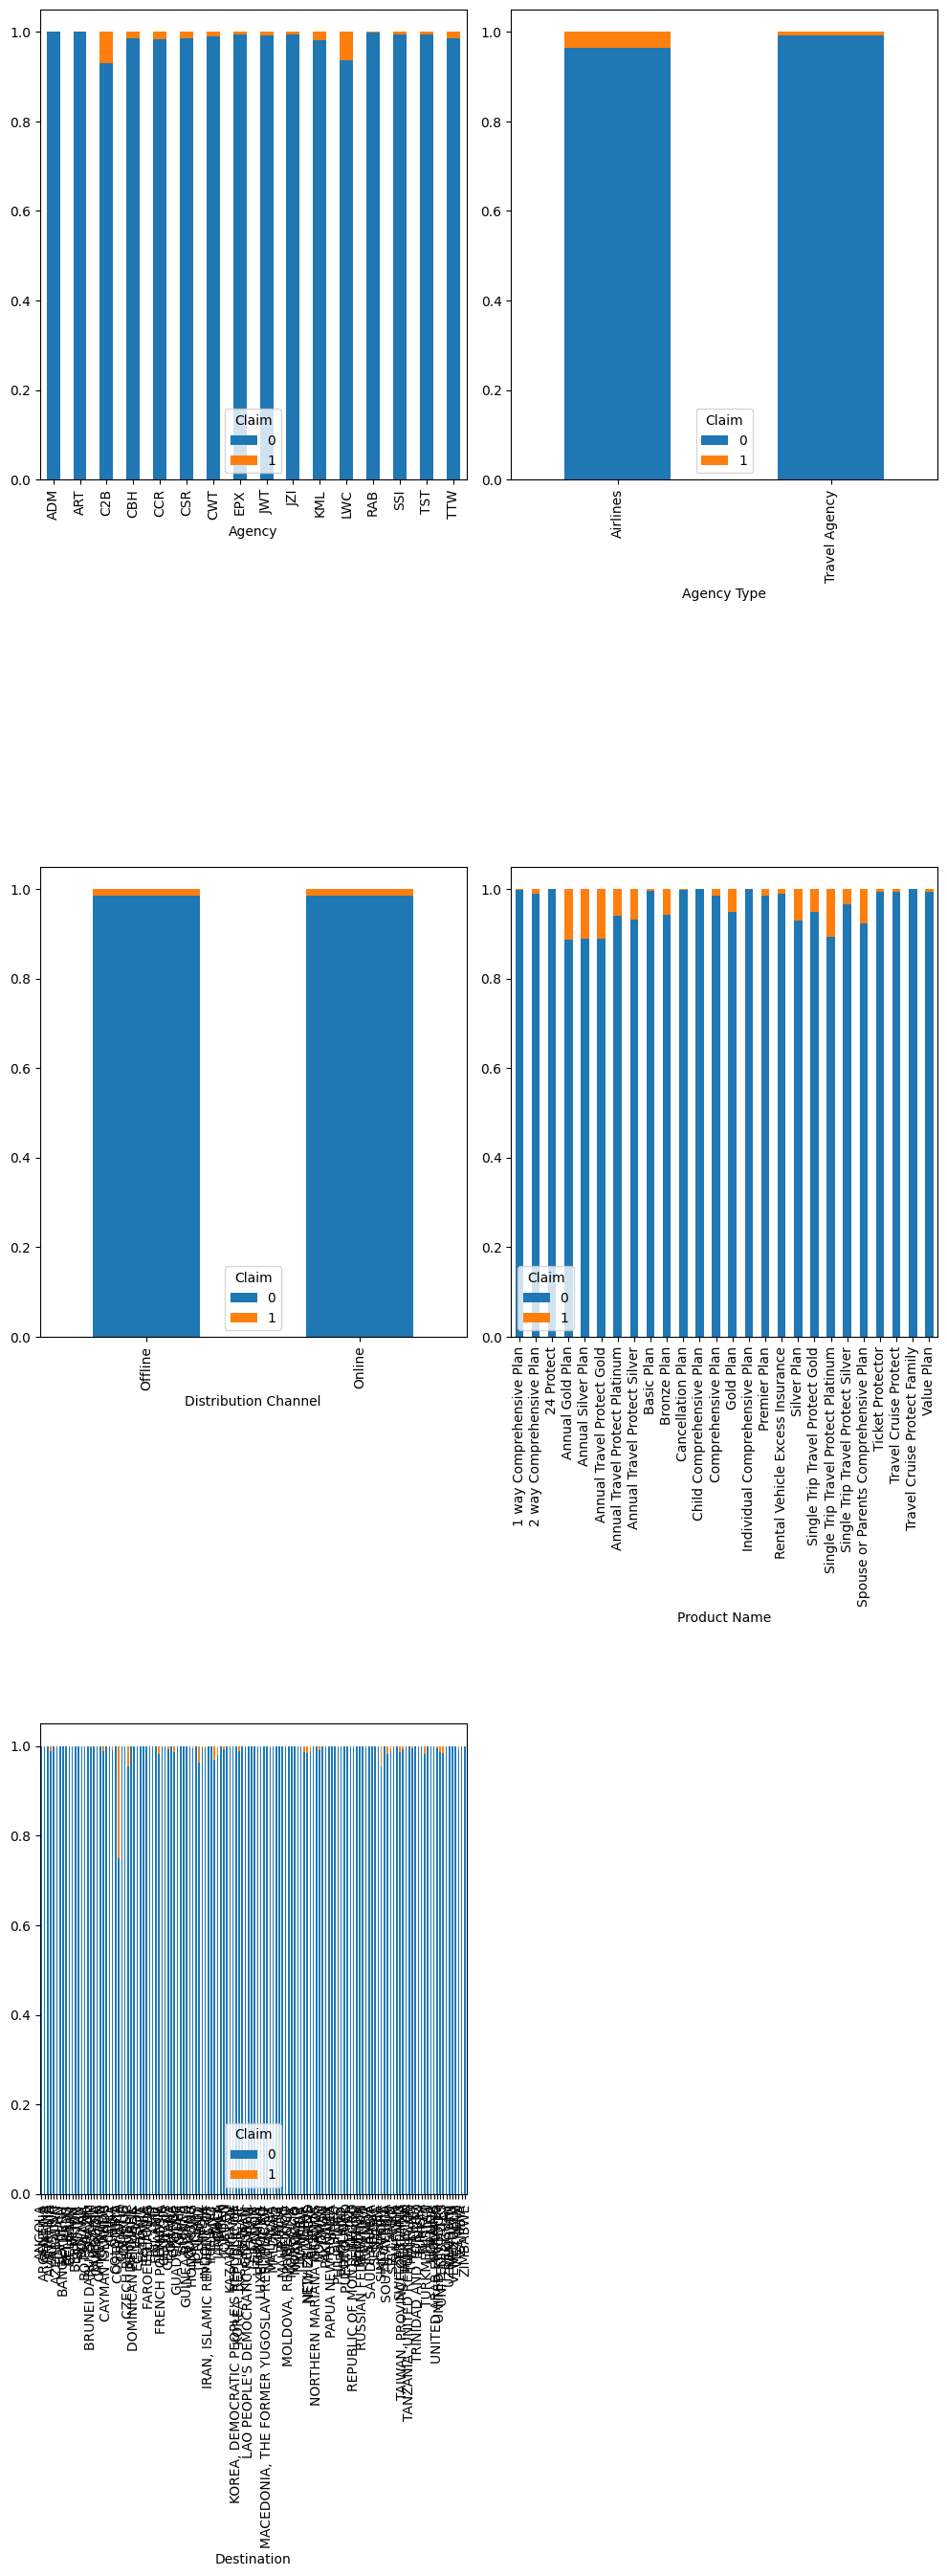

In [11]:
count = 0
fig = plt.figure(figsize=(10,50))

for i in df_cleaned.drop(columns=['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Claim']).columns:
    count +=1
    ax= plt.subplot(6,2,count)
    pd.crosstab(df[i],df['Claim'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Dari grafik di atas, dapat disimpulkan:
1. Agency LWC dan C2B memiliki tingkat claim yang lebih banyak daripada agency lainnya
2. Stakeholder dengan asuransi dari pihak airlines memiliki kecenderungan untuk mengajukan claim
3. Tidak terdapat perbedaan signifikan tingkat pengajuan claim antara distribution channel offline dan online, sehingga dapat dipertimbangkan untuk tidak digunakan dalam analisis
4. Stakeholder dengan Annual Gold Plan, Annual Silver Plan, Annual Travel Protect Gold, Single Trip Travel Protect Platinum memiliki kecenderungan mengajukan claim.
5. Karena jumlah destinasi yang banyak, maka sulit untuk dapat mengambil kesimpulan dari grafik. Maka akan kita zoom in hanya menjadi top 10 destinasi dengan jumlah claim paling banyak.

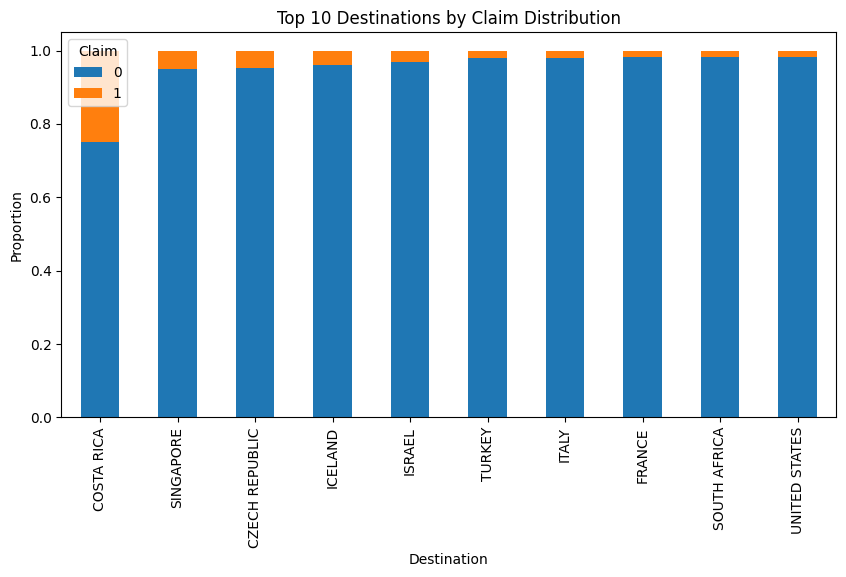

In [12]:
claim_distribution = pd.crosstab(df_cleaned['Destination'], df_cleaned['Claim'], normalize=0)
top_10_destinations = claim_distribution.sort_values(by=1, ascending=False).head(10)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
top_10_destinations.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Top 10 Destinations by Claim Distribution')
ax.set_xlabel('Destination')
ax.set_ylabel('Proportion')

plt.show()


Dari grafik di atas, kita dapat menyimpulkan bahwa stakeholder yang berkunjung ke Costa Rica memiliki tendensi yang lebih tinggi secara signifikan untuk mengajukan claim daripada negara lainnya. Kita juga dapat mengetahui bagaimana distribusi Claim jika destinasi perjalanan dikaji per setiap region. Sehingga dilakukan binning untuk mengelompokkan setiap negara tujuan.

In [13]:
df_cleaned['Destination'].unique()

array(['SINGAPORE', 'MALAYSIA', 'INDIA', 'UNITED STATES',
       'KOREA, REPUBLIC OF', 'THAILAND', 'GERMANY', 'JAPAN', 'INDONESIA',
       'VIET NAM', 'AUSTRALIA', 'FINLAND', 'UNITED KINGDOM', 'SRI LANKA',
       'SPAIN', 'HONG KONG', 'MACAO', 'CHINA', 'UNITED ARAB EMIRATES',
       'IRAN, ISLAMIC REPUBLIC OF', 'TAIWAN, PROVINCE OF CHINA', 'POLAND',
       'CANADA', 'OMAN', 'PHILIPPINES', 'GREECE', 'BELGIUM', 'TURKEY',
       'BRUNEI DARUSSALAM', 'DENMARK', 'SWITZERLAND', 'NETHERLANDS',
       'SWEDEN', 'MYANMAR', 'KENYA', 'CZECH REPUBLIC', 'FRANCE',
       'RUSSIAN FEDERATION', 'PAKISTAN', 'ARGENTINA',
       'TANZANIA, UNITED REPUBLIC OF', 'SERBIA', 'ITALY', 'CROATIA',
       'NEW ZEALAND', 'PERU', 'MONGOLIA', 'CAMBODIA', 'QATAR', 'NORWAY',
       'LUXEMBOURG', 'MALTA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC",
       'ISRAEL', 'SAUDI ARABIA', 'AUSTRIA', 'PORTUGAL', 'NEPAL',
       'UKRAINE', 'ESTONIA', 'ICELAND', 'BRAZIL', 'MEXICO',
       'CAYMAN ISLANDS', 'PANAMA', 'BANGLADESH', 'TURKME

In [14]:
# Define region mapping
region_mapping = {
    "SINGAPORE": "Asia",
    "MALAYSIA": "Asia",
    "INDIA": "Asia",
    "INDONESIA": "Asia",
    "CHINA": "Asia",
    "JAPAN": "Asia",
    "PHILIPPINES": "Asia",
    "THAILAND": "Asia",
    "KOREA, REPUBLIC OF": "Asia",
    "HONG KONG": "Asia",
    "VIETNAM": "Asia",
    "MYANMAR": "Asia",
    "MALDIVES": "Asia",
    "UNITED STATES": "North America",
    "CANADA": "North America",
    "MEXICO": "North America",
    "GERMANY": "Europe",
    "UNITED KINGDOM": "Europe",
    "FRANCE": "Europe",
    "ITALY": "Europe",
    "SPAIN": "Europe",
    "AUSTRIA": "Europe",
    "NETHERLANDS": "Europe",
    "SWITZERLAND": "Europe",
    "RUSSIA": "Europe",
    "BELGIUM": "Europe",
    "CZECH REPUBLIC": "Europe",
    "GREECE": "Europe",
    "AUSTRALIA": "Oceania",
    "NEW ZEALAND": "Oceania",
    "FIJI": "Oceania",
    "UAE": "Middle East",
    "SAUDI ARABIA": "Middle East",
    "ISRAEL": "Middle East",
    "TURKEY": "Middle East",
    "EGYPT": "Middle East",
    "KENYA": "Africa",
    "SOUTH AFRICA": "Africa",
    "NIGERIA": "Africa",
    "TANZANIA": "Africa",
    "MOROCCO": "Africa",
    "BRAZIL": "South America",
    "ARGENTINA": "South America",
    "PERU": "South America",
    "CHILE": "South America",
    "COLOMBIA": "South America",
    "OTHERS": "Others",  
}
df_withreg = df_cleaned
df_withreg['Region'] = df_withreg['Destination'].map(region_mapping).fillna('Others')

df_withreg.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Region
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,0,Asia
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,0,Asia
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,0,Asia
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,0,North America
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,0,Asia


<Axes: xlabel='Region', ylabel='Agency'>

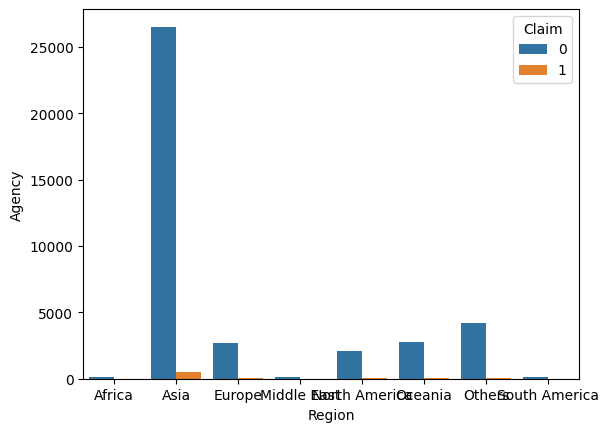

In [15]:
grouped = df_withreg[['Region', 'Claim', 'Agency']].groupby(['Region', 'Claim']).count()
sns.barplot(data=grouped, x='Region', y='Agency', hue='Claim')

Jika dilihat dari grafik per Region, Asia pada umumnya memiliki count Claim lebih banyak daripada negara lainnya, sehingga dapat dikategorikan memiliki resiko yang lebih tinggi selain stakeholder yang berkunjung ke Costarica. Karena terdapat perbedaan kecenderungan claim dilihat dari grafik setiap destinasi, maka dapat diasumsikan bahwa daerah destinasi memiliki pengaruh pada kemungkinan pengajuan claim. 

Untuk menambahkan satu layer pertimbangan lagi dalam pemilihan fitur, kita gunakan analisis chi-square. Untuk fitur dengan p-val dibawa 0.05, maka fitur dianggap berpengaruh pada pengajua Claim.

In [16]:
# Feature Selection (Kategori) dengan chi-square

chi_result = []
for column in df_cleaned.select_dtypes(include=['object']) :
    cont_tabel = pd.crosstab(df_cleaned[column], df_cleaned['Claim'])
    chi2, pval, dof, expected = chi2_contingency(cont_tabel)
    pengaruh = pval < 0.05 # jika p value < 0.05 maka H1 diterima/ True/ fitur berpengaruh
    chi_result.append([column, chi2, pval, pengaruh])

chi_df = pd.DataFrame(
    chi_result,
    columns=['Feature, Chi-Square Statistics, P Value, Berpengaruh Terhadap Target(?)'.split(', ')]
)

chi_df

,Feature,Chi-Square Statistics,P Value,Berpengaruh Terhadap Target(?)
0,Agency,1352.925021,2.211581e-279,True
1,Agency Type,435.216810,1.189777e-96,True
2,Distribution Channel,0.038022,8.453998e-01,False
3,Product Name,1583.577766,0.000000e+00,True
4,Destination,756.191852,2.459576e-86,True
5,Region,56.621680,7.107390e-10,True


Berdasarkan hasil chi-square dan grafik:
1. Distribution Channel tidak akan digunakan karena memiliki nilai pval > 0.05 dan tidak ada perbedaan signifikan di lihat dari grafik.
2. Fitur kategorikal yang akan digunakan adalah Agency, Agency Type, Product Name, Destination berdasarkan nilai pval > 0.05 dan persentase jumlah claim pada barplot.

### Hasil seleksi fitur

Berdasarkan hasil seleksi di atas, maka disimpulkan fitur - fitur yang akan digunakan adalah:
1. Fitur numerik:  Net Sales, Commission (in value)
2. FItur kategori: Agency, Agency Type, Product Name, Destination

In [17]:
df_picked = df_cleaned['Net Sales, Commision (in value), Agency, Agency Type, Product Name, Destination, Claim'.split(', ')]

In [18]:
df_picked.head()

,Net Sales,Commision (in value),Agency,Agency Type,Product Name,Destination,Claim
0,216.0,54.0,C2B,Airlines,Annual Silver Plan,SINGAPORE,0
1,10.0,0.0,EPX,Travel Agency,Cancellation Plan,MALAYSIA,0
2,22.0,7.7,JZI,Airlines,Basic Plan,INDIA,0
3,112.0,0.0,EPX,Travel Agency,2 way Comprehensive Plan,UNITED STATES,0
4,16.0,4.0,C2B,Airlines,Bronze Plan,SINGAPORE,0


## Cek outliers di data numerik

Nilai - nilai outliers di dalam dataframe dapat menarik suatu kesimpulan ke arah ekstrem tertentu karena nilainya terlalu besar, sehingga harus diminimalisir. Pertama - tama yang akan dilakukan adalah memplotkan distribusi nilai pada boxplot untuk mengetahui adanya outliers di dalam kedua fitur yang akan kita gunakan.

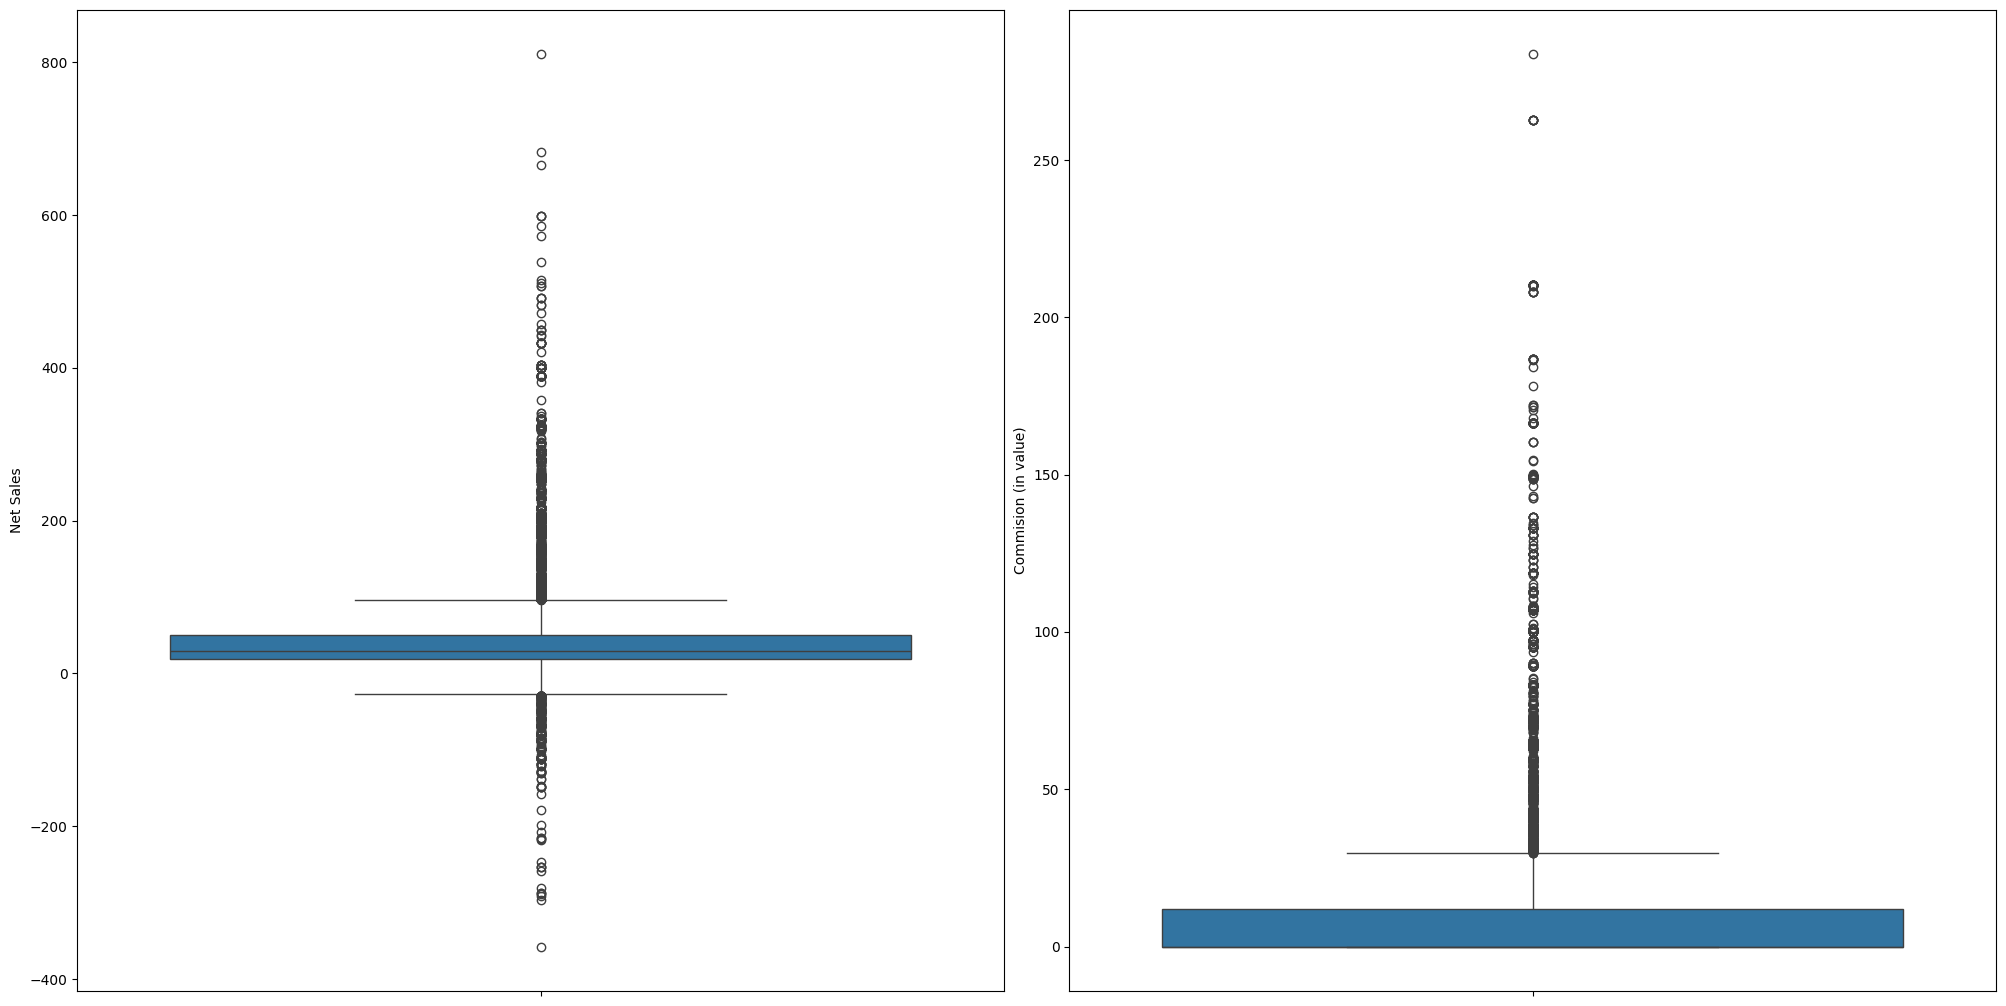

In [19]:
# Outlier Detection
num_features = num_features[['Net Sales', 'Commision (in value)']]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
index = 0
ax = ax.flatten()
for col in num_features:
    sns.boxplot(y=col, data=df_picked, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

Berdasarkan boxplot di atas:
1. Kedua fitur numerik memiliki outliers yang cukup signifikan dan akan diminimalisir.
2. Net sales memiliki nilai negatif yang dapat berarti kerugian. Kemungkinan pertama adalah premi tertanggung lebih rendah dari aktual claim yang muncul. Dengan kata lain, tidak semua resiko tercover oleh premi yang ditentukan di awal. Kemungkinan kedua adalah adanya indikasi asuransi tersebut dicancel.

### Cek net sales bernilai negatif

In [20]:
sales_minus = df_picked[df_picked['Net Sales'] < 0]
percent_sales_minus = round(len(sales_minus)/len(df_picked)*100, 2)

print(f"Status claim dalam Net Sales yang bernilai negatif adalah {sales_minus['Claim'].unique()}")
print(f"Persen Net Sales yang bernilai negatif atau rugi adalah {percent_sales_minus}%")

Status claim dalam Net Sales yang bernilai negatif adalah [0]
Persen Net Sales yang bernilai negatif atau rugi adalah 1.22%


Berdasarkan data di atas, maka kemungkinan pertama sebelumnya gugur karena tidak ada klaim yang muncul (nilai 0) pada Net Sales yang memiliki nilai minus. Artinya claim tidak terbit. Sehingga, kecenderungan kita bergerak pada kemungkinan kedua. Kemungkinan data dengan Net Sales 0 menunjukkan data dari produk yang akhirnya tercancel, nilai minus = refund. Sehingga diputuskan untuk mempertahankan Net Sales bernilai negatif.

### Cek outliers pada Net Sales

In [21]:
net_sales_outliers = df_picked[df_picked['Net Sales'] > 70]
percent_net_sales_outliers = round(len(net_sales_outliers)/len(df_picked)*100, 2)

print(f"Persentase Net Sales yang bernilai di atas 70 {percent_net_sales_outliers}%")

Persentase Net Sales yang bernilai di atas 70 15.48%


In [22]:
# Removing outliers net sales
df_picked = df_picked[(df_picked['Net Sales'] < 70) & (df_picked['Net Sales'] > -21)]
df_picked.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32771 entries, 1 to 44327
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Net Sales             32771 non-null  float64
 1   Commision (in value)  32771 non-null  float64
 2   Agency                32771 non-null  object 
 3   Agency Type           32771 non-null  object 
 4   Product Name          32771 non-null  object 
 5   Destination           32771 non-null  object 
 6   Claim                 32771 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 2.0+ MB


<Axes: ylabel='Net Sales'>

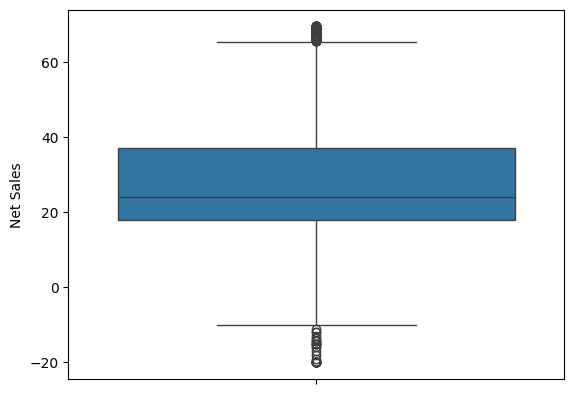

In [23]:
sns.boxplot(y='Net Sales', data=df_picked)

### Cek outliers pada Commision (in value)

In [24]:
commision_outliers = df_picked[df_picked['Commision (in value)'] > 30]
percent_commision_outliers = round(len(commision_outliers)/len(df_picked)*100, 2)

print(f"Persentase Net Sales yang bernilai di atas 18 {percent_commision_outliers}%")

Persentase Net Sales yang bernilai di atas 18 3.48%


In [25]:
# Removing outliers Commision (in value)
df_picked = df_picked[df_picked['Commision (in value)'] < 21]
df_picked.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29963 entries, 1 to 44327
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Net Sales             29963 non-null  float64
 1   Commision (in value)  29963 non-null  float64
 2   Agency                29963 non-null  object 
 3   Agency Type           29963 non-null  object 
 4   Product Name          29963 non-null  object 
 5   Destination           29963 non-null  object 
 6   Claim                 29963 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.8+ MB


<Axes: ylabel='Commision (in value)'>

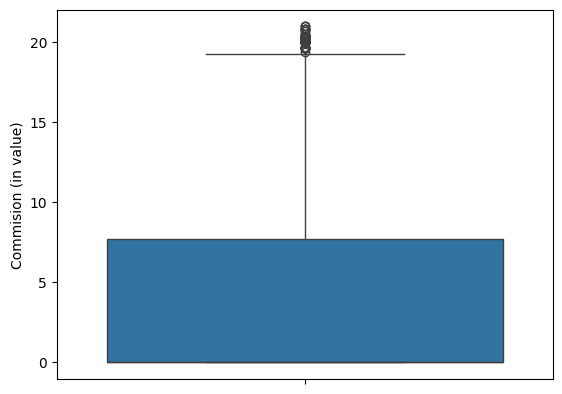

In [26]:
sns.boxplot(y='Commision (in value)', data=df_picked)

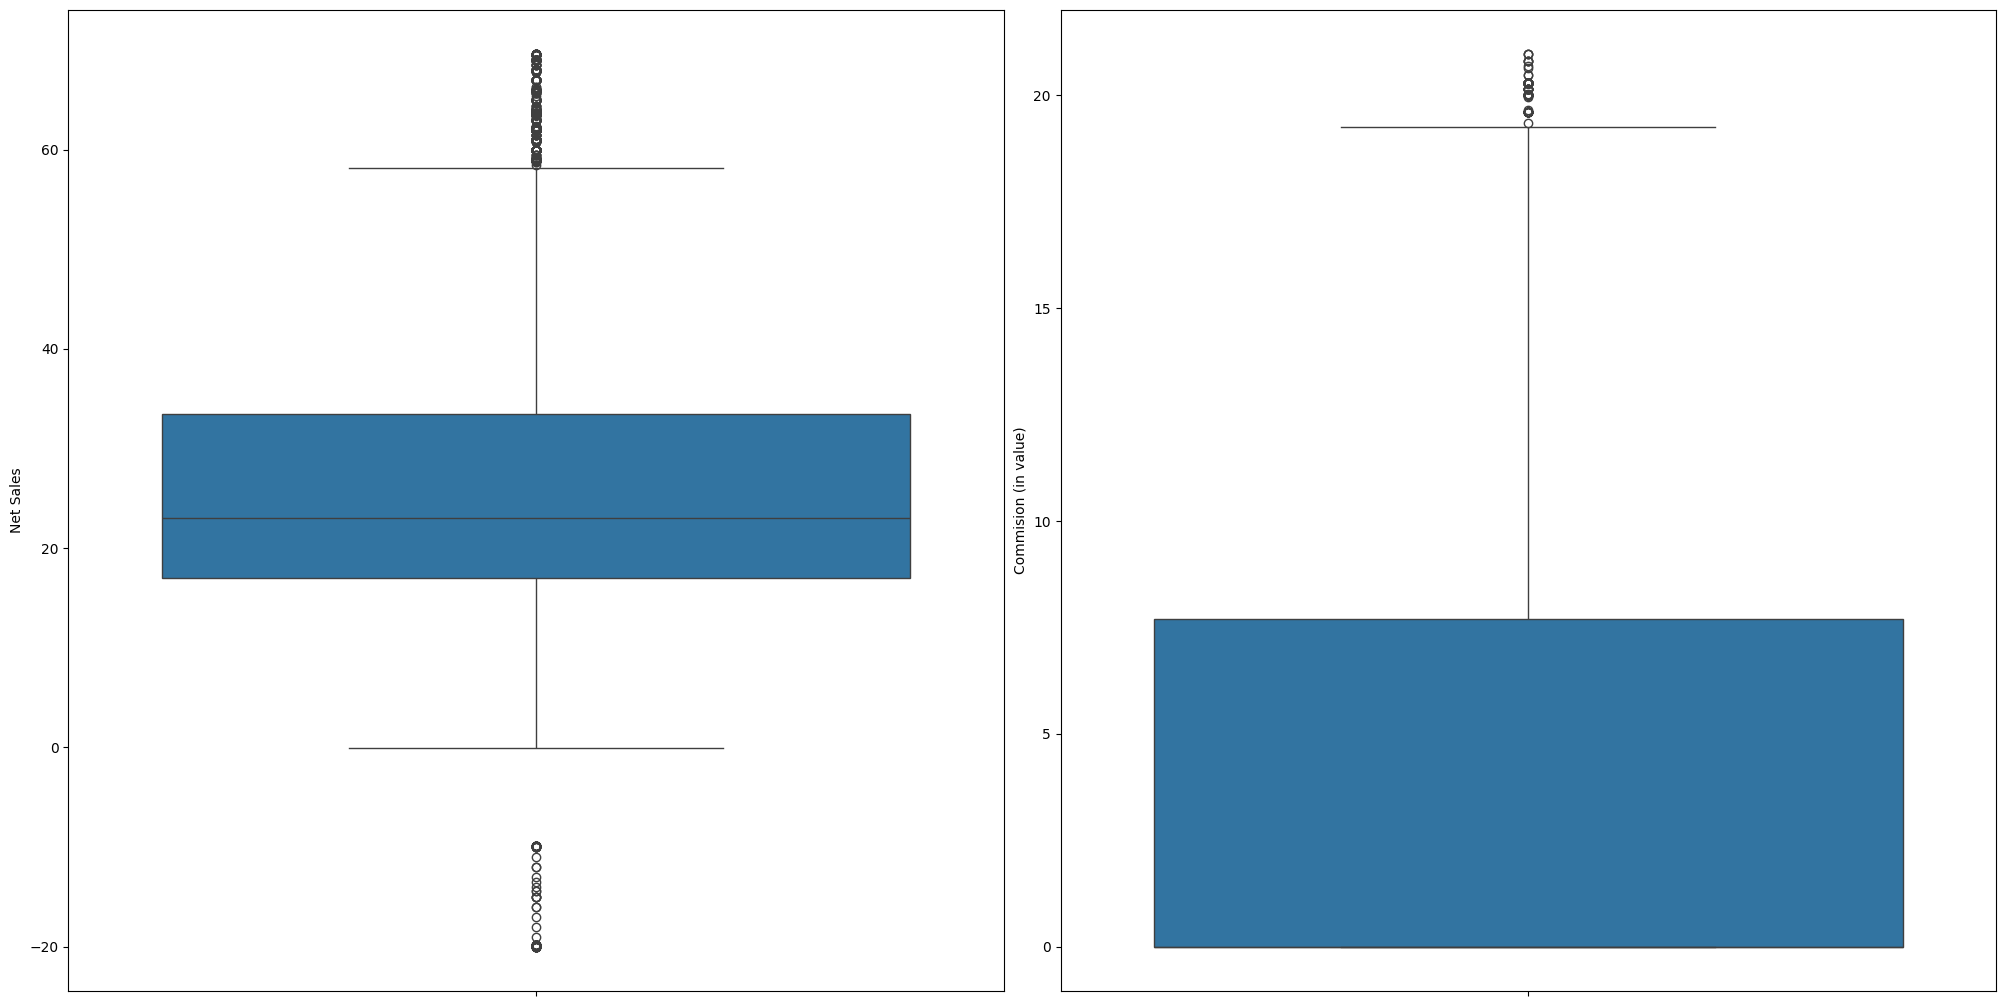

In [27]:
# Outlier Detection
num_features = num_features[['Net Sales', 'Commision (in value)']]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
index = 0
ax = ax.flatten()
for col in num_features:
    sns.boxplot(y=col, data=df_picked, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

# Pre-processing

## Cek distribusi target

Pada pemodelan machine learning, diperlukan adanya jumlah data yang seimbang antara nilai negatif dan nilai positif. Hal ini agar ML memiliki cukup referensi terhadap karakteristik keduanya. Dengan referensi yang cukup maka diharapkan akurasi prediksi pun akan semakin tinggi. Data yang tidak balance antara nilai negatif dan nilai positif biasanya disebut dengan data imbalance. Untuk mengetahui apakah data kita memiliki jumlah yang balance antara nilai negatif dan nilai positif, maka perlu diplotkan dalam barplot.

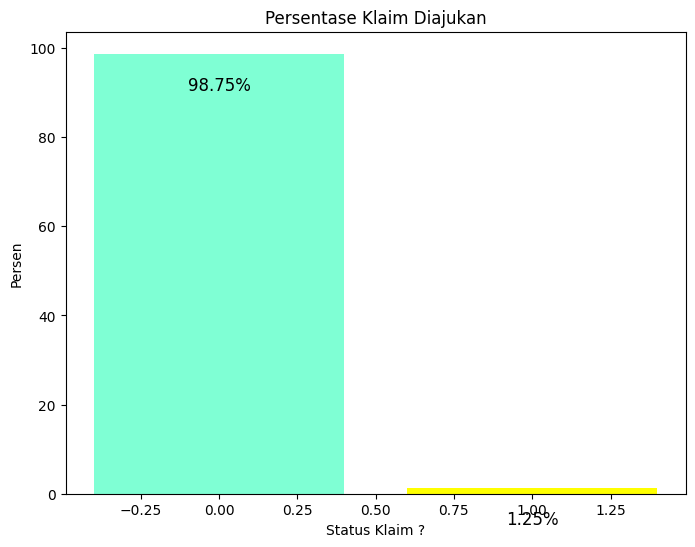

In [28]:
# Check Distribusi Target dengan Barplot

percentage = df_picked['Claim'].value_counts(normalize=True) * 100

plt.figure(figsize=(8,6))

bars = plt.bar(
    percentage.index,
    percentage.values,
    color = ['aquamarine', 'yellow']
)

for bar in bars :
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval-5, f"{round(yval,2)}%", ha='center', va ='top', color='black', fontsize = 12)

plt.xlabel('Status Klaim ?')
plt.ylabel('Persen')
plt.title('Persentase Klaim Diajukan')
plt.show()

Dari barplot di atas diketahui bahwa distribusi data sangat tidak seimbang antara klaim yang diajukan dan tidak diajukan. Sehingga, proses balancing diperlukan. Akan tetapi, terlebih dahulu, untuk mengetahui bagaiman efek dari balancing bekerja, maka kita akan melakukan pengujian awal modeling tanpa balancing.

## Preprocessing pipeline

Seperti yang sudah dijelaskan sebelumnya, karena ML hanya dapat memproses segala data dalam bentuk angka, maka harus dilakukan transformasi terhadap data - data String yang kita miliki dengan melakukan preprocessing. Proses preprocessing ini juga dapat digunakan untuk meratakan nilai - nilai numerik yang rentangnya jauh menjadi lebih 'setara'. Hal yang pertama harus dilakukan dalam preprocessing adalah memetakan setiap fitur yang akan digunakan dan menentukan proses preprocessing apa yang akan kita pakai.

In [29]:
# Extract General Information (Nama Kolom, Tipe Data, Missing Value, % Missing Value, Unique, Sample Unique)

list_item = []
for i in df_picked.columns :
    list_item.append([
        i,
        df_picked[i].dtype,
        df_picked[i].isna().sum(),
        round(df_picked[i].isna().sum()/len(df_picked)*100),
        df_picked[i].nunique(),
        df_picked[i].unique()[:3]
    ])

info_df = pd.DataFrame(list_item,
                       columns='Nama Kolom, Tipe Data, Missing Value, % Missing Value, N Unique, Unique Sampe'.split(', '))
info_df

,Nama Kolom,Tipe Data,Missing Value,% Missing Value,N Unique,Unique Sampe
0,Net Sales,float64,0,0,555,"[10.0, 22.0, 16.0]"
1,Commision (in value),float64,0,0,518,"[0.0, 7.7, 4.0]"
2,Agency,object,0,0,15,"[EPX, JZI, C2B]"
3,Agency Type,object,0,0,2,"[Travel Agency, Airlines]"
4,Product Name,object,0,0,17,"[Cancellation Plan, Basic Plan, Bronze Plan]"
5,Destination,object,0,0,116,"[MALAYSIA, INDIA, SINGAPORE]"
6,Claim,int64,0,0,2,"[0, 1]"


Berdasarkan tabel di atas:
1. Agency : akan dilakukan binary encoding karena memiliki lebih dari 4 unique values dan nilai kategorinya tidak memiliki suatu urutan.
2. Agency Type : akan dilakukan one hot encoding karena hanya terdiri dari 2 nilai unik.
3. Product Name : akan dilakukan binary encoding karena memiliki lebih dari 4 unique values dan nilai kategorinya tidak memiliki suatu urutan.
4. Destination : akan dilakukan binary encoding karena memiliki lebih dari 4 unique values dan nilai kategorinya tidak memiliki suatu urutan.
5. Net Sales dan Commission (in value) memiliki data dengan rentang yang cukup jauh, sehingga agar lebih setara akan dilakukan Robust Scaler.

In [30]:
# Define preprocessing
RB = ['Net Sales', 'Commision (in value)']
BE = ['Agency', 'Product Name', 'Destination']
OH = ['Agency Type']

prepros = ColumnTransformer(
    transformers=[
        ('rb', RobustScaler(), RB),
        ('be', ce.BinaryEncoder(), BE),
        ('OH', OneHotEncoder(handle_unknown='ignore', drop='first'), OH)
    ], remainder='passthrough'
)

prepros

ColumnTransformer(remainder='passthrough',
                  transformers=[('rb', RobustScaler(),
                                 ['Net Sales', 'Commision (in value)']),
                                ('be', BinaryEncoder(),
                                 ['Agency', 'Product Name', 'Destination']),
                                ('OH',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Agency Type'])])

## Split Train and Test

Step kedua adalah menentukan niali X dan y. X akan menjadi independen variabel dengan Y menjadi target variable. Karena tujuan kita untuk mmeprediksi kemungkinan Claim, maka Claim akan menjadi Y. Sedangkan fitur lainnya akan berfungsi sebagai fitur independen yang membentuk Y, yaitu X. Setelah X dan Y sudah didefinisikan, dilakukan pemisahan data antara data train dan data test. Data train akan digunakan untuk membentuk model machine learning. Setelah selesai, model ini akan digunakan untuk memprediksi hasil dari data test.

In [31]:
# Split Data (Train dan Test)

X = df_picked.drop('Claim', axis=1)
y = df_picked['Claim']

xtrain, xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2024,
    stratify=y
)

# Initial Pipeline

Untuk semakin mengerti signifikansi dari balancing, dan apakah proses balancing benar - benar dibutuhkan dalam analisis, sebelum bergerak lebih jauh maka kita akan melakukan proses normal tanpa balancing.

## Pipeline without balancing

Setelah membuat skema preproduction, kita mengenkapsulasi skema tersebut kedalam pipeline yang digabungkan dengan model inisial yaitu Decision Tree.

In [32]:
# Create Pipeline Model Tanpa Balancing

model = DecisionTreeClassifier(random_state=2004, max_depth=5)
pipe_dt = Pipeline([
    ('PrePros', prepros),
    ('Model', model)
])

pipe_dt

Pipeline(steps=[('PrePros',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('rb', RobustScaler(),
                                                  ['Net Sales',
                                                   'Commision (in value)']),
                                                 ('be', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination']),
                                                 ('OH',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Agency Type'])])),
                ('Model',
                 DecisionTreeClassifier(max_depth=5, random_state=2004))])

Dari pipeline di atas, flownya adalah raw data akan masuk kedalam pipeline dan diproses oleh masing - masing preprocessing box sesuai dengan fitur yang sudah diassign untuk box tersebut. Setelah semua raw data ditransformasi, baru modeling dengan Decision Tree dilakukan.

## Fitting initial pipeline to xtest

Setelah pipeline dibuat, pipeline tersebut akan difitting ke data xtrain dan ytrain. Setelah model terlatih, performanya akan diuji coba dengan memprediksi data test yang baru muncul. Setelah hasil prediksi keluar, akan dibuat nilai akurasinya.

In [33]:
# Evaluasi Model

pipe_dt.fit(xtrain, ytrain)
pred = pipe_dt.predict(xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5918
           1       0.00      0.00      0.00        75

    accuracy                           0.99      5993
   macro avg       0.49      0.50      0.50      5993
weighted avg       0.98      0.99      0.98      5993



Dari accuracy report di atas, diketahui bahwa model dapat memprediksi hasil 99% dengan benar. Tapi, ketika kita lihat nilai recall hasilnya 0. Hal ini mungkin terjadi karena model menerima terlalu banyak referensi nilai Negatif, sehingga akan amat kesulitan untuk memprediksi nilai Positif. Hal ini ditunjukkan dari hasil precision, recall, dan f1-score yang 0. Dari sini maka dapat disimpulkan bahwa proses balancing memang diperlukan dalam analisis.

## Pipeline with balancing SMOTE

Untuk memastikan bahwa proses balancing dapat memberikan improvement, maka dilakukan uji coba dengan menggunakan 1 proses balancing. Balancing yang akan digunakan adalah SMOTE dengan modelling Decision Tree.

In [34]:
# Define Oversampling Method

smote = SMOTE(random_state=201)

# Buat Pipeline dengan smote di dalamnya

model = DecisionTreeClassifier(random_state=2004, max_depth=5)
pipe_dt_1 = Pipeline([
    ('PrePros', prepros),
    ('Balancing', smote),
    ('Model', model)
])

pipe_dt_1

Pipeline(steps=[('PrePros',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('rb', RobustScaler(),
                                                  ['Net Sales',
                                                   'Commision (in value)']),
                                                 ('be', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination']),
                                                 ('OH',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Agency Type'])])),
                ('Balancing', SMOTE(random_state=201)),
                ('Model',
                 DecisionTreeClassifier(max_depth=5, random_state=2004))])

## Fit model with pipeline

In [35]:
# Evaluasi Model

pipe_dt_1.fit(xtrain, ytrain)
pred = pipe_dt_1.predict(xtest)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      5918
           1       0.03      0.69      0.07        75

    accuracy                           0.76      5993
   macro avg       0.51      0.73      0.46      5993
weighted avg       0.98      0.76      0.85      5993



Dilihat dari perbandingan nilai recall antara initial model tanpa balancing dengan model yang menggunakan balancing, terdapat peningkatan nilai recall yang signifikan (0% -> 69%), sehingga disimpulkan bahwa memang proses balancing amat diperlukan dalam pembuatan model untuk data seperti ini.

# Model Benchmarking

Setelah memutuskan bahwa perlu dilakukan balancing, maka proses dilanjutkan dengan model benchmarking. Model benchmarking akan digunakan untuk melakukan seleksi terhadap best model di dalam mengolah data perusahaan asuransi.

Karena proses dengan melibatkan model yang banyak membutuhkan waktu lumayan lama, sehingga, untuk menghindari adanya error di akhir proses, kita melakukan uji coba dahulu terhadap beberapa model dengan menggunakan satu balancing method.

## Define models

In [22]:
# Model Benchmarking
dt = DecisionTreeClassifier(max_depth=8, random_state=31, splitter='best', criterion='gini')
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression()
svm = SVC(kernel='rbf')

#Hard vote
hard_vote = VotingClassifier([
    ('KNN', knn),
    ('Log Reg', logreg),
    ('dt', dt)
], voting='hard')

#Soft vote
soft_vote = VotingClassifier([
    ('KNN', knn),
    ('Log Reg', logreg),
    ('dt', dt)
], voting='soft')

#Stacking
stcking = StackingClassifier([
    ('KNN', knn),
    ('Log Reg', logreg),
    ('dt', dt)
], final_estimator=svm)

rf = RandomForestClassifier(n_estimators=300, random_state=202, max_depth=10,
                            criterion='gini', min_samples_split=3) #n_estimator untuk menentukan seberapa banyak tree dalam random forest
adaboost = AdaBoostClassifier(n_estimators=300, random_state=202)
bagging = BaggingClassifier(estimator=logreg) #akan run bootstrap tapi dilakukan logistic regression
xgb = XGBClassifier()
GB = GradientBoostingClassifier(n_estimators=300, random_state=202)

## Models benchmarking with smote

In [ ]:
# Train Model

hasil = []
namaModel = []

models = {
    'DT' : dt,
    'KNN' : knn,
    'Logistic Regression' : logreg,
    'SVC' : svm,
    'Hard Vote' : hard_vote,
    'Soft Vote' : soft_vote,
    'Stacking' : stcking
}

for model in models.items() :
    model_pipe = Pipeline(steps=[
        ('Pre Process', prepros),
        ('Balancing', SMOTE(random_state=31)),
        ('Model', model[1])
    ])

    #Fitting pipeline with cross validation
    cv_score = cross_val_score(model_pipe, xtrain, ytrain, cv = 10, scoring='recall')
    hasil.append({
        'Model' : model[0],
        'Recall' : cv_score,
        'AVG Recall' : cv_score.mean(),
        'Std Recall' : cv_score.std()
    })

In [32]:
pd.DataFrame(hasil).sort_values('AVG Recall', ascending=False)

,Model,Recall,AVG Recall,Std Recall
2,Logistic Regression,"[0.7, 0.6666666666666666, 0.8, 0.7333333333333...",0.691494,0.110241
3,SVC,"[0.7, 0.6333333333333333, 0.7666666666666667, ...",0.668276,0.103503
0,DT,"[0.6333333333333333, 0.6333333333333333, 0.733...",0.641494,0.132591
4,Hard Vote,"[0.6333333333333333, 0.6333333333333333, 0.7, ...",0.628161,0.122284
5,Soft Vote,"[0.6, 0.6, 0.6666666666666666, 0.7, 0.37931034...",0.577931,0.112275
6,Stacking,"[0.6, 0.6, 0.6666666666666666, 0.7, 0.37931034...",0.577931,0.112275
1,KNN,"[0.06666666666666667, 0.0, 0.03333333333333333...",0.040115,0.029035


Dengan metode balancing SMOTE, ternyata hasil logistic regression menunjukkan performa yang lumayan baik dengan nilai recall 69%.
Karena sudah berhasil, maka proses dilanjutkan dengan menggunakan beberapa model dan metode balancing.

## Redefine models

In [36]:
# Model Benchmarking
dt = DecisionTreeClassifier(random_state=31)
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression()
# svm = SVC()

#Hard vote
hard_vote = VotingClassifier([
    ('KNN', knn),
    ('Log Reg', logreg),
    ('dt', dt)
], voting='hard')

# #Stacking
# stcking = StackingClassifier([
#     ('KNN', knn),
#     ('Log Reg', logreg),
#     ('dt', dt)
# ], final_estimator=svm)

rf = RandomForestClassifier(n_estimators=100, random_state=202, max_depth=10,
                            criterion='gini', min_samples_split=3) #n_estimator untuk menentukan seberapa banyak tree dalam random forest
adaboost = AdaBoostClassifier(n_estimators=50, random_state=202)
xgb = XGBClassifier()
GB = GradientBoostingClassifier(n_estimators=100, random_state=202)

## Models benchmarking with all balancing method

In [37]:
# Train Model

hasil = []
namaBalance = []
namaModel = []

# Definisikan balancing methode
balancing_methods = {
    'SMOTE': SMOTE(random_state=201),
    'ADASYN': ADASYN(random_state=201),
    'RandomOverSampler': RandomOverSampler(random_state=201),
    # 'SVMSMOTE': SVMSMOTE(random_state=201),
    'RandomUnderSampler': RandomUnderSampler(random_state=201),
    'NearMiss': NearMiss(version=3),
    'CondensedNearestNeighbour': CondensedNearestNeighbour(random_state=201),
    'TomekLinks': TomekLinks(),
}

models = {
    'DT' : dt,
    'KNN' : knn,
    'Logistic Regression' : logreg,
    'Hard Vote' : hard_vote,
    # 'Stacking' : stcking,
    'Random Forest' : rf,
    'Adaboost' : adaboost,
    'XGB' : xgb,
    'Gradient Boosting' : GB
}

skfold = StratifiedKFold(n_splits=3)

for model in models.items() :
    for i in balancing_methods.items() :
        model_pipe = Pipeline(steps=[
            ('Pre Process', prepros),
            ('Balancing', i[1]),
            ('Model', model[1])
        ])

        #Fitting pipeline with cross validation
        cv_score = cross_val_score(model_pipe, xtrain, ytrain, cv = skfold, scoring='recall', n_jobs=-1)
        hasil.append({
            'Model' : model[0],
            'Balancing Method' : i[0],
            'Recall' : cv_score,
            'AVG Recall' : cv_score.mean(),
            'Std Recall' : cv_score.std()
        })

pd.DataFrame(hasil).sort_values('AVG Recall', ascending=False)

,Model,Balancing Method,Recall,AVG Recall,Std Recall
15,Logistic Regression,ADASYN,"[0.73, 0.69, 0.7]",0.706667,0.016997
14,Logistic Regression,SMOTE,"[0.73, 0.67, 0.7]",0.700000,0.024495
38,Adaboost,RandomUnderSampler,"[0.73, 0.67, 0.68]",0.693333,0.026247
46,XGB,NearMiss,"[0.74, 0.65, 0.67]",0.686667,0.038586
16,Logistic Regression,RandomOverSampler,"[0.72, 0.66, 0.66]",0.680000,0.028284
4,DT,NearMiss,"[0.74, 0.64, 0.65]",0.676667,0.044969
17,Logistic Regression,RandomUnderSampler,"[0.73, 0.65, 0.65]",0.676667,0.037712
52,Gradient Boosting,RandomUnderSampler,"[0.71, 0.62, 0.68]",0.670000,0.037417
39,Adaboost,NearMiss,"[0.72, 0.63, 0.64]",0.663333,0.040277
37,Adaboost,RandomOverSampler,"[0.73, 0.63, 0.63]",0.663333,0.047140


# Hyperparameter Tuning

Dalam proses hyperparameter tuning, hanya 5 kombinasi model dan balancing dengan nilai average recall tertinggi yang akan digunakan. Dalam hal ini berarti kita memiliki:
1. Logistic Regression - Adasyn
2. Logistic Regression - SMOTE
3. Adaboost - Random Under Sampler
4. XGB - Near miss
5. Logistic Regression - Random Over Sampler.

Step - step yang akan dilakukan dari setiap kombinasinya adalah:
1. Menyusun kerangka pipeline dan hyperparam yang akan digunakan dalam uji parameter gridsearch.
2. Melakukan fitting model dengan data train
3. Menguji model dengan parameter terbaik ke datatest
4. Menyimpulkan seluruh hasil recall dari setiap kombinasi dan menentukan model yang terbaik after tuning.

## Tuning Logreg - Adasyn

In [38]:
skfold = StratifiedKFold(n_splits=5)

pipe_1 = Pipeline([
    ('Pre Process', prepros),
    ('Balancing', ADASYN(random_state=201)),
    ('Model', logreg)
])

hyperparam = {
    'Model__C': [0.01, 0.1, 1, 10, 100],
    'Model__penalty': ['l2'],
    'Model__solver': ['lbfgs', 'saga'],
    'Model__max_iter': [100, 200, 500],
    'Model__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    estimator= pipe_1,
    scoring='recall', 
    cv=skfold,
    n_jobs=-1,
    param_grid=hyperparam
    )

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Agency '
                                                                          'Type'])])),
                                       ('Balancing', ADASYN(random_state=201)),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__class_weight': ['balanced', None],
                         'Model__max_iter': [100, 200, 500],
                         'Model__penalty': ['l2'],
                         'Model__solver': ['lbfgs', 'saga']},
             scoring='recall')

In [39]:
grid_search.fit(xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Agency '
                                                                          'Type'])])),
                                       ('Balancing', ADASYN(random_state=201)),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__class_weight': ['balanced', None],
                         'Model__max_iter': [100, 200, 500],
                         'Model__penalty': ['l2'],
                         'Model__solver': ['lbfgs', 'saga']},
             scoring='recall')

In [40]:
grid_search.best_params_

{'Model__C': 100,
 'Model__class_weight': None,
 'Model__max_iter': 100,
 'Model__penalty': 'l2',
 'Model__solver': 'lbfgs'}

In [41]:
best_model = grid_search.best_estimator_
ypred = best_model.predict(xtest)
recall_val1 = recall_score(ytest, ypred)
cm = confusion_matrix(ytest, ypred)

print("Recall Score for Model 1:", recall_val1)
print("Confusion Matrix for Model 1:\n", cm)

Recall Score for Model 1: 0.72
Confusion Matrix for Model 1:
 [[4637 1281]
 [  21   54]]


In [42]:
hasil_tuning = []
hasil_tuning.append({
    'Model' : "Logistic Regression",
    'Balancing Method' : "ADASYN",
    'Recall after tuning' : grid_search.best_score_,
    'Recall score to data test' : recall_val1
})

pd.DataFrame(hasil_tuning).sort_values('Recall after tuning', ascending=False)

,Model,Balancing Method,Recall after tuning,Recall score to data test
0,Logistic Regression,ADASYN,0.696667,0.72


## Tuning Logreg - Smote

In [43]:
pipe_2 = Pipeline([
    ('Pre Process', prepros),
    ('Balancing', SMOTE(random_state=201)),
    ('Model', logreg)
])

hyperparam2 = {
    'Model__C': [0.01, 0.1, 1, 10, 100],
    'Model__penalty': ['l2'],
    'Model__solver': ['lbfgs', 'saga'],
    'Model__max_iter': [100, 200, 500],
    'Model__class_weight': ['balanced', None]
}

grid_search2 = GridSearchCV(
    estimator= pipe_2,
    scoring='recall', 
    cv=skfold,
    n_jobs=-1,
    param_grid=hyperparam2
    )

grid_search2

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Agency '
                                                                          'Type'])])),
                                       ('Balancing', SMOTE(random_state=201)),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__class_weight': ['balanced', None],
                         'Model__max_iter': [100, 200, 500],
                         'Model__penalty': ['l2'],
                         'Model__solver': ['lbfgs', 'saga']},
             scoring='recall')

In [44]:
grid_search2.fit(xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Agency '
                                                                          'Type'])])),
                                       ('Balancing', SMOTE(random_state=201)),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__class_weight': ['balanced', None],
                         'Model__max_iter': [100, 200, 500],
                         'Model__penalty': ['l2'],
                         'Model__solver': ['lbfgs', 'saga']},
             scoring='recall')

In [45]:
grid_search2.best_params_

{'Model__C': 1,
 'Model__class_weight': 'balanced',
 'Model__max_iter': 100,
 'Model__penalty': 'l2',
 'Model__solver': 'lbfgs'}

In [46]:
best_model2 = grid_search2.best_estimator_
ypred2 = best_model2.predict(xtest)
recall_val2 = recall_score(ytest, ypred2)
cm2 = confusion_matrix(ytest, ypred2)

print("Recall Score for Model 2:", recall_val2)
print("Confusion Matrix for Model 2:\n", cm2)

Recall Score for Model 2: 0.72
Confusion Matrix for Model 2:
 [[4698 1220]
 [  21   54]]


In [47]:
hasil_tuning.append({
    'Model' : "Logistic Regression",
    'Balancing Method' : "SMOTE",
    'Recall after tuning' : grid_search2.best_score_,
    'Recall score to data test' : recall_val2
})

pd.DataFrame(hasil_tuning).sort_values('Recall after tuning', ascending=False)

,Model,Balancing Method,Recall after tuning,Recall score to data test
0,Logistic Regression,ADASYN,0.696667,0.72
1,Logistic Regression,SMOTE,0.680000,0.72


## Tuning Adaboost - Random Under Sampler

In [52]:
base_estimators = [
    DecisionTreeClassifier(max_depth=1, min_samples_split=2),
    DecisionTreeClassifier(max_depth=2, min_samples_split=5),
    DecisionTreeClassifier(max_depth=3, min_samples_split=10),
    DecisionTreeClassifier(max_depth=5, min_samples_split=10)
]

pipe_3 = Pipeline([
    ('Pre Process', prepros),
    ('Balancing', RandomUnderSampler(random_state=201)),
    ('Model', adaboost)
])

hyperparam3 = {
    'Model__n_estimators': [50, 100, 200],
    'Model__learning_rate': [0.01, 0.1, 1.0],
    'Model__algorithm': ['SAMME', 'SAMME.R'],
    'Model__estimator': base_estimators
}

grid_search3 = GridSearchCV(
    estimator= pipe_3,
    scoring='recall', 
    cv=skfold,
    n_jobs=-1,
    param_grid=hyperparam3
    )

grid_search3

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ign...
             param_grid={'Model__algorithm': ['SAMME', 'SAMME.R'],
                         'Model__estimator': [DecisionTreeClassifier(max_depth=1),
                                              DecisionTreeClassifier(max_depth=2,
                                                                     min_samples_split=5),
                                              DecisionTreeClassifier(max_depth=3,
                                                                     min_samples_split=10),
                                              DecisionTreeClassifier(max_depth=5,
                                                                     min_samples_split=10)],
                         'Model__learning_rate': [0.01, 0.1, 1.0],
                         'Model__n_estimators': [50, 100, 200]},
             scoring='recall')

In [53]:
grid_search3.fit(xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ign...
             param_grid={'Model__algorithm': ['SAMME', 'SAMME.R'],
                         'Model__estimator': [DecisionTreeClassifier(max_depth=1),
                                              DecisionTreeClassifier(max_depth=2,
                                                                     min_samples_split=5),
                                              DecisionTreeClassifier(max_depth=3,
                                                                     min_samples_split=10),
                                              DecisionTreeClassifier(max_depth=5,
                                                                     min_samples_split=10)],
                         'Model__learning_rate': [0.01, 0.1, 1.0],
                         'Model__n_estimators': [50, 100, 200]},
             scoring='recall')

In [67]:
grid_search3.best_params_

{'Model__algorithm': 'SAMME.R',
 'Model__estimator': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
 'Model__learning_rate': 0.01,
 'Model__n_estimators': 50}

In [54]:
best_model3 = grid_search3.best_estimator_
ypred3 = best_model3.predict(xtest)
recall_val3 = recall_score(ytest, ypred3)
cm3 = confusion_matrix(ytest, ypred3)

print("Recall Score for Model 3:", recall_val3)
print("Confusion Matrix for Model 3:\n", cm3)

Recall Score for Model 3: 0.7733333333333333
Confusion Matrix for Model 3:
 [[4393 1525]
 [  17   58]]


In [55]:
hasil_tuning.append({
    'Model' : "Adaboost",
    'Balancing Method' : "Random Under Sampler",
    'Recall after tuning' : grid_search3.best_score_,
    'Recall score to data test' : recall_val3
})

pd.DataFrame(hasil_tuning).sort_values('Recall after tuning', ascending=False)

,Model,Balancing Method,Recall after tuning,Recall score to data test
2,Adaboost,Random Under Sampler,0.720000,0.773333
0,Logistic Regression,ADASYN,0.696667,0.720000
1,Logistic Regression,SMOTE,0.680000,0.720000


## Tuning XGB - Near Miss

In [56]:
pipe_4 = Pipeline([
    ('Pre Process', prepros),
    ('Balancing', NearMiss(version=3)),
    ('Model', xgb)
])

hyperparam4 = {
    'Model__n_estimators': [50, 100, 200],
    'Model__learning_rate': [0.01, 0.1, 0.2],
    'Model__max_depth': [3, 5, 7],
    'Model__min_child_weight': [1, 3, 5],
    'Model__gamma': [0, 1, 5],
    'Model__subsample': [0.6, 0.8, 1.0],
    'Model__colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search4 = GridSearchCV(
    estimator= pipe_4,
    scoring='recall', 
    cv=skfold,
    n_jobs=-1,
    param_grid=hyperparam4
    )

grid_search4

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ign...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Model__colsample_bytree': [0.6, 0.8, 1.0],
                         'Model__gamma': [0, 1, 5],
                         'Model__learning_rate': [0.01, 0.1, 0.2],
                         'Model__max_depth': [3, 5, 7],
                         'Model__min_child_weight': [1, 3, 5],
                         'Model__n_estimators': [50, 100, 200],
                         'Model__subsample': [0.6, 0.8, 1.0]},
             scoring='recall')

In [57]:
grid_search4.fit(xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ign...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Model__colsample_bytree': [0.6, 0.8, 1.0],
                         'Model__gamma': [0, 1, 5],
                         'Model__learning_rate': [0.01, 0.1, 0.2],
                         'Model__max_depth': [3, 5, 7],
                         'Model__min_child_weight': [1, 3, 5],
                         'Model__n_estimators': [50, 100, 200],
                         'Model__subsample': [0.6, 0.8, 1.0]},
             scoring='recall')

In [68]:
grid_search4.best_params_

{'Model__colsample_bytree': 1.0,
 'Model__gamma': 0,
 'Model__learning_rate': 0.2,
 'Model__max_depth': 7,
 'Model__min_child_weight': 1,
 'Model__n_estimators': 200,
 'Model__subsample': 0.8}

In [58]:
best_model4 = grid_search4.best_estimator_
ypred4 = best_model4.predict(xtest)
recall_val4 = recall_score(ytest, ypred4)
cm4 = confusion_matrix(ytest, ypred4)

print("Recall Score for Model 4:", recall_val4)
print("Confusion Matrix for Model 4:\n", cm4)

Recall Score for Model 4: 0.6933333333333334
Confusion Matrix for Model 4:
 [[4180 1738]
 [  23   52]]


In [59]:
hasil_tuning.append({
    'Model' : "XGBoost",
    'Balancing Method' : "Near Miss",
    'Recall after tuning' : grid_search4.best_score_,
    'Recall score to data test' : recall_val4
})

pd.DataFrame(hasil_tuning).sort_values('Recall after tuning', ascending=False)

,Model,Balancing Method,Recall after tuning,Recall score to data test
3,XGBoost,Near Miss,0.736667,0.693333
2,Adaboost,Random Under Sampler,0.720000,0.773333
0,Logistic Regression,ADASYN,0.696667,0.720000
1,Logistic Regression,SMOTE,0.680000,0.720000


## Tuning Logreg - Random Over Sampler

In [60]:
pipe_5 = Pipeline([
    ('Pre Process', prepros),
    ('Balancing', RandomOverSampler(random_state=201)),
    ('Model', logreg)
])

hyperparam5 = {
    'Model__C': [0.01, 0.1, 1, 10, 100],
    'Model__penalty': ['l2'],
    'Model__solver': ['lbfgs', 'saga'],
    'Model__max_iter': [100, 200, 500],
    'Model__class_weight': ['balanced', None]
}

grid_search5 = GridSearchCV(
    estimator= pipe_5,
    scoring='recall', 
    cv=skfold,
    n_jobs=-1,
    param_grid=hyperparam5
    )

grid_search5

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Agency '
                                                                          'Type'])])),
                                       ('Balancing',
                                        RandomOverSampler(random_state=201)),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__class_weight': ['balanced', None],
                         'Model__max_iter': [100, 200, 500],
                         'Model__penalty': ['l2'],
                         'Model__solver': ['lbfgs', 'saga']},
             scoring='recall')

In [61]:
grid_search5.fit(xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('Pre Process',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rb',
                                                                         RobustScaler(),
                                                                         ['Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)']),
                                                                        ('be',
                                                                         BinaryEncoder(),
                                                                         ['Agency',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('OH',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Agency '
                                                                          'Type'])])),
                                       ('Balancing',
                                        RandomOverSampler(random_state=201)),
                                       ('Model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__class_weight': ['balanced', None],
                         'Model__max_iter': [100, 200, 500],
                         'Model__penalty': ['l2'],
                         'Model__solver': ['lbfgs', 'saga']},
             scoring='recall')

In [62]:
grid_search5.best_params_

{'Model__C': 100,
 'Model__class_weight': 'balanced',
 'Model__max_iter': 100,
 'Model__penalty': 'l2',
 'Model__solver': 'lbfgs'}

In [63]:
best_model5 = grid_search5.best_estimator_
ypred5 = best_model5.predict(xtest)
recall_val5 = recall_score(ytest, ypred5)
cm5 = confusion_matrix(ytest, ypred5)

print("Recall Score for Model 5:", recall_val5)
print("Confusion Matrix for Model 5:\n", cm5)

Recall Score for Model 5: 0.72
Confusion Matrix for Model 5:
 [[4811 1107]
 [  21   54]]


In [64]:
hasil_tuning.append({
    'Model' : "Logistic Regression",
    'Balancing Method' : "Random Over Sampler",
    'Recall after tuning' : grid_search5.best_score_,
    'Recall score to data test' : recall_val5
})

pd.DataFrame(hasil_tuning).sort_values('Recall after tuning', ascending=False)

,Model,Balancing Method,Recall after tuning,Recall score to data test
3,XGBoost,Near Miss,0.736667,0.693333
2,Adaboost,Random Under Sampler,0.720000,0.773333
0,Logistic Regression,ADASYN,0.696667,0.720000
4,Logistic Regression,Random Over Sampler,0.690000,0.720000
1,Logistic Regression,SMOTE,0.680000,0.720000


Setelah dilakukan hyperparameter tuning, didapatkan XGBoost dengan balancing Near Miss memiliki nilai recall yang paling tinggi. Akan tetapi, ketika dibandingan dengan data test, nilai recall menurun dari 73% menjadi 69%. Sehingga, kombinasi di peringkat pertama tidak dapat kita jadikan model yang paling baik. Selanjutnya adalah model kombinasi Adaboost dengan balancing Random Under Sampler. Setelah dituning, model yang tadinya memiliki average nilai recall 69%, dapat meningkat menjadi 72%. Performa ini justru semakin meningkat pada nilai recall hasil fitting di data test yaitu 77%. Oleh karena itu disimpulkan bahwa model terbaik untuk memprediksi adanya pengajuan claim asuransi perjalanan kita adalah dengan Adaboost dan balancing Random Under Sampler.

Algoritma AdaBoost (Adaptive Boosting) adalah suatu algoritma yang masih termasuk ke dalam grup ensemble learning. AdaBoost akan menggunakan serangkaian weak learners untuk ditraining secara berurutan, yang mana, pada setiap prosesnya akan berusaha memperbaiki kesalahan yang dilakukan oleh model sebelumnya. Proses perbaikan ini dilakukan dengan cara memberikan bobot yang lebih berat pada setiap kesalahan yang terjadi, sehingga model berikutnya dapat berfokus untuk memperbaiki kesalahan - kesalahan tersebut. Weak learner yang paling sering digunakan dalam Adaboost adalah Decision Stump.

# Feature Importances

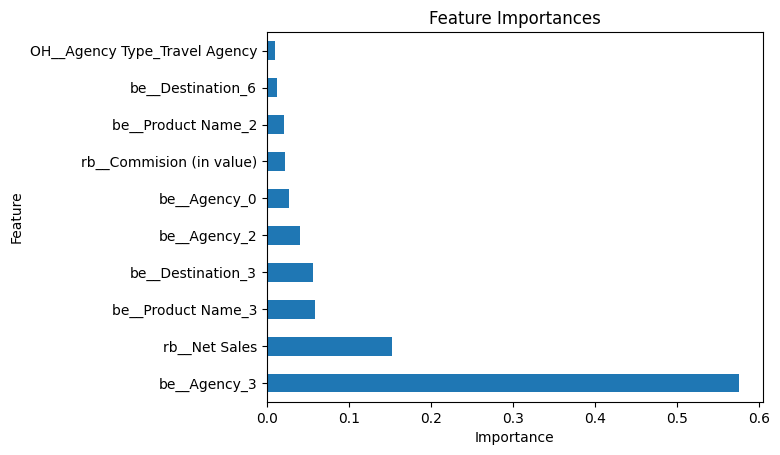

In [ ]:
preprocessor = best_model3.named_steps['Pre Process']
adaboost_model = best_model3.named_steps['Model']
feature_names = preprocessor.get_feature_names_out()
feature_importances = adaboost_model.feature_importances_
coef1 = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False).head(10)

coef1.plot(kind='barh', title='Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Dari grafik di atas, terlihat bahwa fitur yang paling berpengaruh dari adaboost modelinng kita adalah agency. Yang kedua adalah net sales, lalu product name dan destination dengan selisih yang sedikit.

# Conclusion

In [84]:
report = classification_report(ytest, ypred3)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      5918
           1       0.04      0.77      0.07        75

    accuracy                           0.74      5993
   macro avg       0.52      0.76      0.46      5993
weighted avg       0.98      0.74      0.84      5993



Dilihat dari classification report di atas, kita dapat mengambil kesimpulan:

1. Nilai recall class negative adalah 74%, artinya, model dapat memprediksi 74% dari konsumen yang benar - benar tidak mengajukan klaim, dan model dapat menebak 77% konsumen yang akan mengajukan klaim.

2. Nilai recall class positive sebesar 77% artinya, hanya akan ada 23% konsumen yang diprediksi tidak mengajukan klaim padahal akan mengajukan klaim. 

3. Tanpa adanya penggunaan model, perusahaan akan berada pada dua pilihan, yaitu menganggap semua trip adalah high risk (segala resiko tercover) atau menganggap semua trip tidak high risk (harga bersaing).

4. Jika harga high risk trip berada pada kisaran ($150–$350), dan low risk trip pada kisaran $80–$150, maka:
- pada opsi semua trip adalah high risk maka kemungkinan setiap resiko dapat tercover akan tetapi premi yang ditawarkan tidak akan bersaing dari produk lainnya.
- pada opsi semua trip adalah low risk, maka jika ada 200 orang konsumen, dimana 100 orang tidak mengajukan klaim, dan 100 orang lainnya mengajukan klaim, akan ada resiko dari 100 orang yang aktualnya mengajukan klaim tidak tercover.
- diprediksi tidak mengajukan klaim = 200 * $150 = $30,000
- aktual tidak mengajukan klaim = 100 * $150 = $15,000
- aktual mengajukan klaim = 100 * $350 = $35,000
--> Resiko tidak tercover yang menjadi kerugian perusahaan = $30,000 - ($15,000+$35,000) = -$20,000

5. Setelah menggunakan model machine learning, kondisi prediksi akan menjadi sebagai berikut:
- diprediksi tidak mengajukan klaim = 100 * $150 = $15,000
- diprediksi mengajukan klaim = 77 * $350 = $26,950  
--> total premi yang didapatkan = $15,000 + $26,950 = $41,950
- aktual tidak mengajukan klaim = 100 * $150 = $15,000
- diprediksi mengajukan klaim = 100 * $350 = $35,000  
--> total resiko = $15,000 + $35,000 = $50,000  
--> Resiko tidak tercover yang menjadi kerugian perusahaan = $41,950 - $50,000 = -$8,050  
--> Penurunan defisit yaitu $20,000 - $8,050 = $11,950  

# Save to Pickle

In [85]:
import pickle

In [86]:
filename = 'adaboost.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model3, file)

print("Model saved successfully!")


Model saved successfully!
